# DenseNet Implementation with Corrected Variable Handling

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cpu


## Complete Code with Data Loading and Model Training

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
from torch.utils.data import DataLoader, Subset
import numpy as np
import time

# Define Bottleneck Layer
class Bottleneck(nn.Module):
    def __init__(self, in_channels, growth_rate):
        super(Bottleneck, self).__init__()
        self.bn1 = nn.BatchNorm2d(in_channels)
        self.conv1 = nn.Conv2d(in_channels, 4 * growth_rate, kernel_size=1, bias=False)
        self.bn2 = nn.BatchNorm2d(4 * growth_rate)
        self.conv2 = nn.Conv2d(4 * growth_rate, growth_rate, kernel_size=3, padding=1, bias=False)

    def forward(self, x):
        out = self.conv1(F.relu(self.bn1(x)))
        out = self.conv2(F.relu(self.bn2(out)))
        out = torch.cat([out, x], 1)
        return out

# Define Transition Layer
class Transition(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(Transition, self).__init__()
        self.bn = nn.BatchNorm2d(in_channels)
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False)

    def forward(self, x):
        out = self.conv(F.relu(self.bn(x)))
        out = nn.functional.avg_pool2d(out, 2)
        return out

# Define DenseNet
class DenseNet(nn.Module):
    def __init__(self, growth_rate, block_config, reduction=0.5, num_classes=10):
        super(DenseNet, self).__init__()
        num_channels = 2 * growth_rate
        self.conv1 = nn.Conv2d(3, num_channels, kernel_size=7, stride=2, padding=3, bias=False)

        self.dense1 = self._make_dense(num_channels, growth_rate, block_config[0])
        num_channels += growth_rate * block_config[0]
        out_channels = int(num_channels * reduction)
        self.trans1 = Transition(num_channels, out_channels)

        num_channels = out_channels
        self.dense2 = self._make_dense(num_channels, growth_rate, block_config[1])
        num_channels += growth_rate * block_config[1]
        out_channels = int(num_channels * reduction)
        self.trans2 = Transition(num_channels, out_channels)

        num_channels = out_channels
        self.dense3 = self._make_dense(num_channels, growth_rate, block_config[2])
        num_channels += growth_rate * block_config[2]
        out_channels = int(num_channels * reduction)
        self.trans3 = Transition(num_channels, out_channels)

        num_channels = out_channels
        self.dense4 = self._make_dense(num_channels, growth_rate, block_config[3])
        num_channels += growth_rate * block_config[3]

        self.bn = nn.BatchNorm2d(num_channels)
        self.fc = nn.Linear(num_channels, num_classes)

    def _make_dense(self, in_channels, growth_rate, num_layers):
        layers = []
        for i in range(num_layers):
            layers.append(Bottleneck(in_channels + i * growth_rate, growth_rate))
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv1(x)
        out = nn.functional.relu(out)
        out = nn.functional.avg_pool2d(out, 3, stride=2, padding=1)

        out = self.dense1(out)
        out = self.trans1(out)
        out = self.dense2(out)
        out = self.trans2(out)
        out = self.dense3(out)
        out = self.trans3(out)
        out = self.dense4(out)

        out = F.relu(self.bn(out))
        out = F.adaptive_avg_pool2d(out, (1, 1))
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

# CIFAR-10 Data Loading and Preprocessing
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

#full_trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

#subset_indices = np.random.choice(len(full_trainset), len(full_trainset) // 10, replace=False)
#trainset = Subset(full_trainset, subset_indices)
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True, num_workers=0)



100%|██████████| 170498071/170498071 [00:01<00:00, 86447338.79it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data


In [4]:
import matplotlib.pyplot as plt
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False, num_workers=0)

Files already downloaded and verified


In [5]:
def trainx(model,trainloader,criterion,optimizer):



    # Training Loop with error logging
    train_losses = []
    test_losses = []
    test_accuracies = []
    start_time = time.time()
    for epoch in range(100):  # Number of epochs
        model.train()  # Set the model to training mode
        running_loss = 0.0
        for i, (inputs, labels) in enumerate(trainloader):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        # Calculate average loss for this epoch
        avg_train_loss = running_loss / len(trainloader)
        train_losses.append(avg_train_loss)

        # Evaluate on test data
        test_loss, test_accuracy = evaluate_model(model, testloader, criterion)
        test_losses.append(test_loss)
        test_accuracies.append(test_accuracy)

        # Print training and test results for each epoch
        print(f'Epoch {epoch+1}/{100}, Train Loss: {avg_train_loss:.4f}, Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%')

    end_time = time.time()
    total_training_time = end_time - start_time
    print(f"Total training time: {total_training_time:.2f} seconds")
    print('Finished Training')

    # Plotting Loss and Accuracy
    plt.figure(figsize=(12, 5))

    # Loss Plot
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(test_losses, label='Test Loss')
    plt.title('Loss over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Accuracy Plot
    plt.subplot(1, 2, 2)
    plt.plot(test_accuracies, label='Test Accuracy')
    plt.title('Test Accuracy over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()

    plt.show()
    return


In [6]:
# Function to evaluate the model
def evaluate_model(model, testloader, criterion):
    model.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    test_accuracy = 100 * correct / total
    return test_loss / len(testloader), test_accuracy

In [7]:
  #10 classes in CIFAR-10
num_classes = 10
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# Function to evaluate the model on the test data and get misclassifications
def evaluate_model_with_misclassifications(model, testloader, criterion):
    model.eval()  # Set the model to evaluation mode
    class_correct = list(0. for i in range(num_classes))
    class_total = list(0. for i in range(num_classes))
    class_incorrect = list(0. for i in range(num_classes))

    with torch.no_grad():
        for images, labels in testloader:
            images, labels = images.to(device), labels.to(device)  # Move data to GPU
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            c = (predicted == labels).squeeze()
            for i in range(len(labels)):
                label = labels[i]
                class_correct[label] += c[i].item()
                class_total[label] += 1
                if not c[i].item():
                    class_incorrect[label] += 1

    for i in range(num_classes):
        if class_total[i] > 0:
            print(f'Accuracy of {class_names[i]} : {100 * class_correct[i] / class_total[i]:.2f}%')
            print(f'Misclassifications of {class_names[i]} : {class_incorrect[i]}')
        else:
            print(f'Accuracy of {class_names[i]} : N/A (No samples)')
            print(f'Misclassifications of {class_names[i]} : N/A (No samples)')

# Use this function for evaluation


Epoch 1/100, Train Loss: 1.6797, Test Loss: 1.4697, Test Accuracy: 46.44%
Epoch 2/100, Train Loss: 1.3366, Test Loss: 1.2732, Test Accuracy: 54.54%
Epoch 3/100, Train Loss: 1.1450, Test Loss: 1.0907, Test Accuracy: 61.33%
Epoch 4/100, Train Loss: 1.0025, Test Loss: 0.9055, Test Accuracy: 68.72%
Epoch 5/100, Train Loss: 0.8851, Test Loss: 0.9009, Test Accuracy: 69.27%
Epoch 6/100, Train Loss: 0.7993, Test Loss: 0.8187, Test Accuracy: 71.65%
Epoch 7/100, Train Loss: 0.7406, Test Loss: 0.7781, Test Accuracy: 72.68%
Epoch 8/100, Train Loss: 0.6913, Test Loss: 0.7001, Test Accuracy: 75.69%
Epoch 9/100, Train Loss: 0.6501, Test Loss: 0.6766, Test Accuracy: 76.59%
Epoch 10/100, Train Loss: 0.5991, Test Loss: 0.6414, Test Accuracy: 77.55%
Epoch 11/100, Train Loss: 0.5806, Test Loss: 0.6401, Test Accuracy: 77.90%
Epoch 12/100, Train Loss: 0.5440, Test Loss: 0.6425, Test Accuracy: 77.54%
Epoch 13/100, Train Loss: 0.5166, Test Loss: 0.6260, Test Accuracy: 78.80%
Epoch 14/100, Train Loss: 0.4949, 

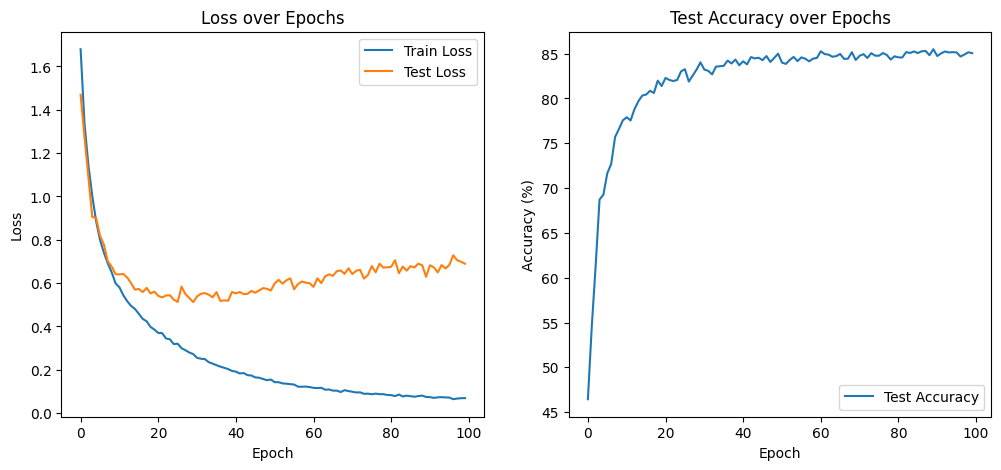

Accuracy of airplane : 86.50%
Misclassifications of airplane : 135.0
Accuracy of automobile : 92.30%
Misclassifications of automobile : 77.0
Accuracy of bird : 78.40%
Misclassifications of bird : 216.0
Accuracy of cat : 73.10%
Misclassifications of cat : 269.0
Accuracy of deer : 84.70%
Misclassifications of deer : 153.0
Accuracy of dog : 77.00%
Misclassifications of dog : 230.0
Accuracy of frog : 90.60%
Misclassifications of frog : 94.0
Accuracy of horse : 88.50%
Misclassifications of horse : 115.0
Accuracy of ship : 89.40%
Misclassifications of ship : 106.0
Accuracy of truck : 90.90%
Misclassifications of truck : 91.0


In [8]:
model= DenseNet(block_config=[6, 12, 24, 16], growth_rate=32, num_classes=10)
model.to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = torch.nn.CrossEntropyLoss()
trainx(model,trainloader,criterion,optimizer)
evaluate_model_with_misclassifications(model, testloader, criterion)

Epoch 1/100, Train Loss: 1.8499, Test Loss: 1.9116, Test Accuracy: 36.43%
Epoch 2/100, Train Loss: 1.5976, Test Loss: 1.5043, Test Accuracy: 47.17%
Epoch 3/100, Train Loss: 1.3951, Test Loss: 1.4989, Test Accuracy: 48.82%
Epoch 4/100, Train Loss: 1.1799, Test Loss: 1.1335, Test Accuracy: 60.12%
Epoch 5/100, Train Loss: 1.0421, Test Loss: 0.9700, Test Accuracy: 65.91%
Epoch 6/100, Train Loss: 0.9422, Test Loss: 0.8830, Test Accuracy: 68.53%
Epoch 7/100, Train Loss: 0.8575, Test Loss: 0.8399, Test Accuracy: 70.30%
Epoch 8/100, Train Loss: 0.7588, Test Loss: 0.8338, Test Accuracy: 71.80%
Epoch 9/100, Train Loss: 0.6865, Test Loss: 0.7259, Test Accuracy: 75.06%
Epoch 10/100, Train Loss: 0.6394, Test Loss: 0.6619, Test Accuracy: 77.44%
Epoch 11/100, Train Loss: 0.6109, Test Loss: 0.6526, Test Accuracy: 77.65%
Epoch 12/100, Train Loss: 0.5634, Test Loss: 0.6318, Test Accuracy: 77.88%
Epoch 13/100, Train Loss: 0.5259, Test Loss: 0.6337, Test Accuracy: 78.72%
Epoch 14/100, Train Loss: 0.4981, 

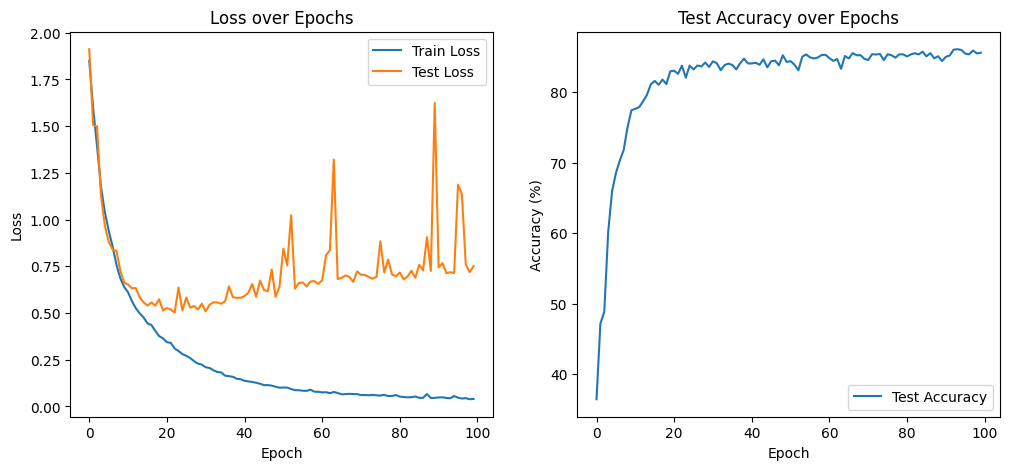

NameError: ignored

In [15]:
model1= DenseNet(block_config=[6, 12, 24, 16], growth_rate=64, num_classes=10)
model1.to(device)
optimizer = optim.Adam(model1.parameters(), lr=0.001)
criterion = torch.nn.CrossEntropyLoss()
trainx(model1,trainloader,criterion,optimizer)
evaluate_model_with_misclassifications(model1, testloader, criterion)

In [17]:

evaluate_model_with_misclassifications(model1, testloader, criterion)

Accuracy of airplane : 84.80%
Misclassifications of airplane : 152.0
Accuracy of automobile : 92.40%
Misclassifications of automobile : 76.0
Accuracy of bird : 77.70%
Misclassifications of bird : 223.0
Accuracy of cat : 78.10%
Misclassifications of cat : 219.0
Accuracy of deer : 85.90%
Misclassifications of deer : 141.0
Accuracy of dog : 75.40%
Misclassifications of dog : 246.0
Accuracy of frog : 90.00%
Misclassifications of frog : 100.0
Accuracy of horse : 85.20%
Misclassifications of horse : 148.0
Accuracy of ship : 92.60%
Misclassifications of ship : 74.0
Accuracy of truck : 89.70%
Misclassifications of truck : 103.0


In [ ]:
model2= DenseNet(block_config=[6, 12, 32, 32], growth_rate=32, num_classes=10)
model2.to(device)
optimizer = optim.Adam(model2.parameters(), lr=0.001)
criterion = torch.nn.CrossEntropyLoss()
trainx(model2,trainloader,criterion,optimizer)
evaluate_model_with_misclassifications(model2, testloader, criterion)

Epoch 1/100, Train Loss: 1.7897, Test Loss: 1.9372, Test Accuracy: 41.10%
Epoch 2/100, Train Loss: 1.4870, Test Loss: 1.4851, Test Accuracy: 47.49%
Epoch 3/100, Train Loss: 1.2515, Test Loss: 1.1693, Test Accuracy: 58.68%
Epoch 4/100, Train Loss: 1.1388, Test Loss: 1.1066, Test Accuracy: 60.80%
Epoch 5/100, Train Loss: 0.9938, Test Loss: 1.0713, Test Accuracy: 62.66%
Epoch 6/100, Train Loss: 0.9100, Test Loss: 0.8873, Test Accuracy: 68.92%
Epoch 7/100, Train Loss: 0.8366, Test Loss: 0.8620, Test Accuracy: 69.95%
Epoch 8/100, Train Loss: 0.7672, Test Loss: 0.8186, Test Accuracy: 71.58%
Epoch 9/100, Train Loss: 0.7158, Test Loss: 0.7689, Test Accuracy: 73.44%
Epoch 10/100, Train Loss: 0.6914, Test Loss: 0.7358, Test Accuracy: 75.19%
Epoch 11/100, Train Loss: 0.6337, Test Loss: 0.6902, Test Accuracy: 76.46%
Epoch 12/100, Train Loss: 0.5956, Test Loss: 0.6566, Test Accuracy: 77.56%
Epoch 13/100, Train Loss: 0.5693, Test Loss: 0.6320, Test Accuracy: 78.05%
Epoch 14/100, Train Loss: 0.5419, 

In [ ]:
model3= DenseNet(block_config=[6, 12, 32, 32], growth_rate=64, num_classes=10)
model3.to(device)
optimizer = optim.Adam(model3.parameters(), lr=0.001)
criterion = torch.nn.CrossEntropyLoss()
trainx(model3,trainloader,criterion,optimizer)
evaluate_model_with_misclassifications(model3, testloader, criterion)

In [ ]:
model4= DenseNet(block_config=[6, 12, 12, 8], growth_rate=32, num_classes=10)
model4.to(device)
optimizer = optim.Adam(model4.parameters(), lr=0.001)
criterion = torch.nn.CrossEntropyLoss()
trainx(model4,trainloader,criterion,optimizer)
evaluate_model_with_misclassifications(model4, testloader, criterion)

In [ ]:
model5= DenseNet(block_config=[6, 12, 12, 8], growth_rate=64, num_classes=10)
model5.to(device)
optimizer = optim.Adam(model5.parameters(), lr=0.001)
criterion = torch.nn.CrossEntropyLoss()
trainx(model5,trainloader,criterion,optimizer)
evaluate_model_with_misclassifications(model5, testloader, criterion)